[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


BoW Confusion Matrix:
 [[1442   11]
 [  24  195]]
BoW Precision: 0.9466019417475728
BoW Recall: 0.8904109589041096
BoW AUC: 0.9698623851769445

TF-IDF Confusion Matrix:
 [[1453    0]
 [  64  155]]
TF-IDF Precision: 1.0
TF-IDF Recall: 0.7077625570776256
TF-IDF AUC: 0.971047148554243


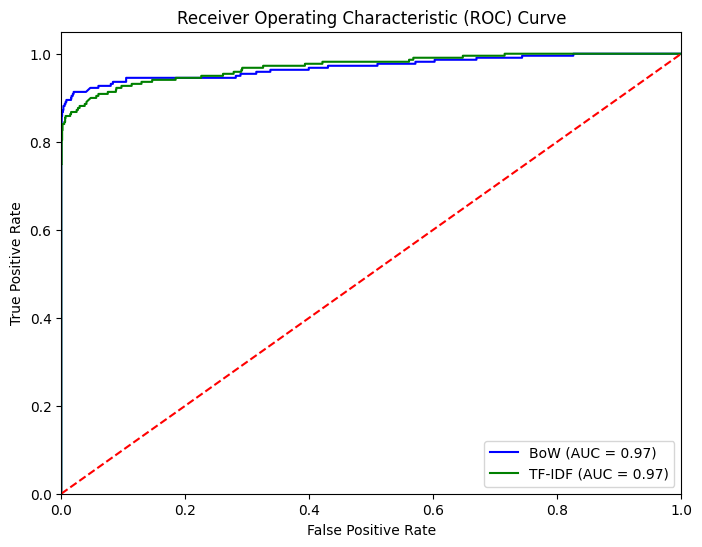

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Descargar recursos de NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar datos
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')

# Función de preprocesamiento de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenizar texto
    tokens = word_tokenize(text)
    # Eliminar stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatizar palabras
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Reconstruir texto preprocesado
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Aplicar preprocesamiento a la columna de texto
df['v2_processed'] = df['v2'].apply(preprocess_text)

# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['v2_processed'], df['v1'], test_size=0.3, random_state=42)

# Crear modelo BoW (n = 1)
count_vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

# Crear modelo TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Entrenar modelo de clasificación Naive Bayes con BoW
nb_classifier_bow = MultinomialNB()
nb_classifier_bow.fit(X_train_bow, y_train)
y_pred_bow = nb_classifier_bow.predict(X_test_bow)

# Entrenar modelo de clasificación Naive Bayes con TF-IDF
nb_classifier_tfidf = MultinomialNB()
nb_classifier_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_classifier_tfidf.predict(X_test_tfidf)

# Calcular métricas
# Matriz de confusión
confusion_matrix_bow = confusion_matrix(y_test, y_pred_bow)
confusion_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)

# Precision y recall
precision_bow = precision_score(y_test, y_pred_bow, pos_label='spam')
recall_bow = recall_score(y_test, y_pred_bow, pos_label='spam')

precision_tfidf = precision_score(y_test, y_pred_tfidf, pos_label='spam')
recall_tfidf = recall_score(y_test, y_pred_tfidf, pos_label='spam')

# Curva ROC y AUC
y_probs_bow = nb_classifier_bow.predict_proba(X_test_bow)[:,1]
fpr_bow, tpr_bow, _ = roc_curve(y_test, y_probs_bow, pos_label='spam')
roc_auc_bow = roc_auc_score(y_test, y_probs_bow)

y_probs_tfidf = nb_classifier_tfidf.predict_proba(X_test_tfidf)[:,1]
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, y_probs_tfidf, pos_label='spam')
roc_auc_tfidf = roc_auc_score(y_test, y_probs_tfidf)

# Mostrar resultados
print("BoW Confusion Matrix:\n", confusion_matrix_bow)
print("BoW Precision:", precision_bow)
print("BoW Recall:", recall_bow)
print("BoW AUC:", roc_auc_bow)

print("\nTF-IDF Confusion Matrix:\n", confusion_matrix_tfidf)
print("TF-IDF Precision:", precision_tfidf)
print("TF-IDF Recall:", recall_tfidf)
print("TF-IDF AUC:", roc_auc_tfidf)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_bow, tpr_bow, color='blue', label='BoW (AUC = %0.2f)' % roc_auc_bow)
plt.plot(fpr_tfidf, tpr_tfidf, color='green', label='TF-IDF (AUC = %0.2f)' % roc_auc_tfidf)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
